<a href="https://www.coursera.org/"><img src = "https://www.toptools4learning.com/wp-content/uploads/2018/09/coursera-300x156.png" width = 150> </a>

<h1 align=center><font size = 5>Choosing what type of Night venue should be opened
    </font></h1>

## Introduction

I will use Jupyter Notebook to develop the work necessary for my Capstone Project to conclude Coursera's Applied Data Science Capstone course. My "client" is my imaginary friend Louis who wants to open a Nightlife Spot in a building he inherited on the 11th Arrondissement of Paris. Louis question is what type of nightlife venue should he open. In order to help him decide I will be clustering the neighborhoods of Paris based on what type of nightlife venues are most common in each one. After clustering, I will verify which venue is below average in the target neighborhood compared to other neighborhoods from same cluster. Based on that information I will give my suggestion to Louis.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pylab as pl

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import math

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Neighborhood Data

We will obtain information about neighborhoods of Paris with some Web scraping. In Wikipedia we can find a list of the neighborhoods from Paris: https://en.wikipedia.org/wiki/Arrondissements_of_Paris

In [2]:
import requests
import lxml.html as lh
import pandas as pd
from bs4 import BeautifulSoup

url='https://en.wikipedia.org/wiki/Arrondissements_of_Paris'
#Create a handle, page, to handle the contents of the website
page = requests.get(url).text

soup = BeautifulSoup(page,'lxml')

#Store the contents of the website under my_table
My_table = soup.find('table',{'class':'wikitable sortable'})

NBData=pd.DataFrame(columns = ['Nr', 'Name', 'Area', 'Density'],index= range(0,20))

row_marker = 0
for tr in My_table.find_all('tr')[1:]:
    tds = tr.find_all('td')
    NBData.iat[row_marker,0] = tds[0].text
    NBData.iat[row_marker,1] = tds[1].text
    NBData.iat[row_marker,2] = tds[2].text
    NBData.iat[row_marker,3] = tds[5].text
    row_marker = row_marker+1

NBData

,Nr,Name,Area,Density
0,1st (Ie) R,Louvre,1.826 km2 (0.705 sq mi),"9,693"
1,2nd (IIe) R,Bourse,0.992 km2 (0.383 sq mi),"20,867"
2,3rd (IIIe) R,Temple,1.171 km2 (0.452 sq mi),"29,974"
3,4th (IVe) R,Hôtel-de-Ville,1.601 km2 (0.618 sq mi),"17,864"
4,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),"23,849"
5,6th (VIe) L,Luxembourg,2.154 km2 (0.832 sq mi),"20,984"
6,7th (VIIe) L,Palais-Bourbon,4.088 km2 (1.578 sq mi),"13,552"
7,8th (VIIIe) R,Élysée,3.881 km2 (1.498 sq mi),"9,972"
8,9th (IXe) R,Opéra,2.179 km2 (0.841 sq mi),"26,847"
9,10th (Xe) R,Entrepôt,2.892 km2 (1.117 sq mi),"30,705"


#### Lets clean the data

In [3]:
#For 12th and 16th neighborhoods there are 2 values for Area and Density, lets remove the wrong one
NBData.iat[11,2] = '6.377'
NBData.iat[15,2] = '7.846'
NBData.iat[11,3] = '21,687'
NBData.iat[15,3] = '19,0544'

#Now lets remove extra information from Nr and Area fields
NBData['Area'] = NBData['Area'].str[:5]
NBData['Nr'] = NBData['Nr'].str[:4]
NBData=NBData.apply(lambda x: x.str.replace(' ',''))

#And convert Area and Density to floats
NBData=NBData.apply(lambda x: x.str.replace(',','.'))
NBData["Area"] = pd.to_numeric(NBData["Area"])
NBData["Density"] = pd.to_numeric(NBData["Density"])

#Finally we want to convert Area into an approximate Radius in meters that can be used later in foursquare
NBData["Radius"] = NBData["Area"].apply(lambda x: math.sqrt(x/3.14)*1000)
#NBData["Radius"] = 100
NBData["Radius"] = NBData["Radius"].astype(int)

NBData

,Nr,Name,Area,Density,Radius
0,1st,Louvre,1.826,9.6930,762
1,2nd,Bourse,0.992,20.8670,562
2,3rd,Temple,1.171,29.9740,610
3,4th,Hôtel-de-Ville,1.601,17.8640,714
4,5th,Panthéon,2.541,23.8490,899
5,6th,Luxembourg,2.154,20.9840,828
6,7th,Palais-Bourbon,4.088,13.5520,1141
7,8th,Élysée,3.881,9.9720,1111
8,9th,Opéra,2.179,26.8470,833
9,10th,Entrepôt,2.892,30.7050,959


Lets add columns for Latitude and Longitude.

In [4]:
# define the dataframe columns for Latitude and Longitude
NBData['Latitude'] = 0
NBData['Longitude'] = 0

NBData

,Nr,Name,Area,Density,Radius,Latitude,Longitude
0,1st,Louvre,1.826,9.6930,762,0,0
1,2nd,Bourse,0.992,20.8670,562,0,0
2,3rd,Temple,1.171,29.9740,610,0,0
3,4th,Hôtel-de-Ville,1.601,17.8640,714,0,0
4,5th,Panthéon,2.541,23.8490,899,0,0
5,6th,Luxembourg,2.154,20.9840,828,0,0
6,7th,Palais-Bourbon,4.088,13.5520,1141,0,0
7,8th,Élysée,3.881,9.9720,1111,0,0
8,9th,Opéra,2.179,26.8470,833,0,0
9,10th,Entrepôt,2.892,30.7050,959,0,0


#### Use geopy library to get the latitude and longitude values for each neighborhood.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>to_explorer</em>, as shown below.

In [5]:
for i in range(0,len(NBData)):

 address = NBData.loc[i,'Nr']+' arrondissement, Paris, France'

 geolocator = Nominatim(user_agent="to_explorer")
 location = geolocator.geocode(address)

 #Insert coordinates in table
 NBData.loc[i,'Latitude'] = location.latitude
 NBData.loc[i,'Longitude'] = location.longitude

NBData.sort_values(by=['Name'], inplace = True)

NBData

,Nr,Name,Area,Density,Radius,Latitude,Longitude
16,17th,Batignolles-Monceau,5.669,28.2770,1343,48.884224,2.322364
1,2nd,Bourse,0.992,20.8670,562,48.868743,2.341688
17,18th,Butte-Montmartre,6.005,31.4240,1382,48.890012,2.346467
18,19th,Buttes-Chaumont,6.786,27.5860,1470,48.889343,2.384360
9,10th,Entrepôt,2.892,30.7050,959,48.876106,2.359910
12,13th,Gobelins,7.146,25.3710,1508,48.832397,2.355583
3,4th,Hôtel-de-Ville,1.601,17.8640,714,48.856202,2.355619
0,1st,Louvre,1.826,9.6930,762,48.864614,2.334396
5,6th,Luxembourg,2.154,20.9840,828,48.850433,2.332951
19,20th,Ménilmontant,5.984,32.0520,1380,48.865042,2.398929


#### Create a map of Paris with neighborhoods superimposed on top.

In [6]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)

#Insert coordinates in table
latitude = location.latitude
longitude = location.longitude

# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(NBData['Latitude'], NBData['Longitude'], NBData['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'C550ANKK5ZIN3YPRHBEGMWH4TKVETKFDYKLMG4J4NJ525CQ1' # your Foursquare ID
CLIENT_SECRET = 'RVMBRD03GDVO4RPMBAC1DWLTJDZBXMQJG0BIM3QGX0MKBCED' # your Foursquare Secret
VERSION = '20190529' # Foursquare API version
LIMIT=1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: C550ANKK5ZIN3YPRHBEGMWH4TKVETKFDYKLMG4J4NJ525CQ1
CLIENT_SECRET:RVMBRD03GDVO4RPMBAC1DWLTJDZBXMQJG0BIM3QGX0MKBCED


Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

## Explore Neighborhoods in Paris

#### Let's create a function to get information for nightlife spots in all neighborhoods in Paris

In [9]:
def getNearbyNightlifeSpots(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes,radius):
        print(name)
            
        # create the API request URL, note that we select categorie of Nightlife Spots only
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06376d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
         
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now lets run the above function on each neighborhood and create a new dataframe called *paris_venues*.

In [10]:
# type your answer here
paris_venues = getNearbyNightlifeSpots(names=NBData['Name'],
                                   latitudes=NBData['Latitude'],
                                   longitudes=NBData['Longitude'],
                                   radius=NBData['Radius']
                                  )

Batignolles-Monceau
Bourse
Butte-Montmartre
Buttes-Chaumont
Entrepôt
Gobelins
Hôtel-de-Ville
Louvre
Luxembourg
Ménilmontant
Observatoire
Opéra
Palais-Bourbon
Panthéon
Passy
Popincourt
Reuilly
Temple
Vaugirard
Élysée


#### Let's check the size of the resulting dataframe

In [11]:
print(paris_venues.shape)
paris_venues.columns = paris_venues.columns.str.replace(' ', '_')
paris_venues.head()
paris_venues.shape

(1559, 7)


(1559, 7)

#### Let's find out how many unique categories can be curated from all the returned venues

In [12]:
paris_venues['Venue_Category'].unique()

array(['Wine Bar', 'Bar', 'French Restaurant',
       'Latin American Restaurant', 'Gastropub', 'Italian Restaurant',
       'Pub', 'Beer Bar', 'Lounge', 'Thai Restaurant', 'Restaurant',
       'Cocktail Bar', 'Breakfast Spot', 'Hotel Bar', 'BBQ Joint',
       'Cheese Shop', 'Music Venue', 'Bistro', 'Beer Garden', 'Nightclub',
       'Diner', 'Concert Hall', 'Karaoke Bar', 'Wine Shop',
       'Mexican Restaurant', 'Dive Bar', 'Hotel', 'Miscellaneous Shop',
       'Office', 'American Restaurant', 'Brewery', 'Comedy Club',
       'Steakhouse', 'Café', 'Sports Bar', 'Vietnamese Restaurant',
       'Record Shop', 'Piano Bar', 'Rock Club', 'Beer Store',
       'Spanish Restaurant', 'Smoke Shop', 'Distillery',
       'Egyptian Restaurant', 'African Restaurant', 'Tapas Restaurant',
       'Mediterranean Restaurant', 'Roof Deck', 'Speakeasy',
       'Coffee Shop', 'Hookah Bar', 'Cajun / Creole Restaurant',
       'Russian Restaurant', 'Gay Bar', 'Jazz Club', 'Boat or Ferry',
       'Japanese R

#### There are some venues which are not exactly nightlife spots so lets clean the data

In [13]:
#We remove restaurants, hotels as they are not strict nightlife spots. We also remove Bar as it is too generic
for i in range(len(paris_venues)):
   if paris_venues['Venue_Category'].isin({'BBQ Joint','Breakfast Spot','Office','Steakhouse','Hotel','Boat or Ferry','Pizza Place', 'Bar'})[i]:
     paris_venues.iat[i,6]='Restaurant'
   elif paris_venues['Venue_Category'].isin({'Beer Garden','Brewery','Beer Store'})[i]:
     paris_venues.iat[i,6]='Beer Bar'
   elif paris_venues['Venue_Category'].isin({'Wine Shop'})[i]:
     paris_venues.iat[i,6]='Wine Bar'
   elif paris_venues['Venue_Category'].isin({'Gastropub'})[i]:
     paris_venues.iat[i,6]='Pub'
        
paris_venues=paris_venues[~paris_venues.Venue_Category.str.contains("Restaurant")]

#Lets reset the index
paris_venues.index = range(len(paris_venues))

paris_venues.head(5)

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Batignolles-Monceau,48.884224,2.322364,L'Établi,48.886150,2.320512,Wine Bar
1,Batignolles-Monceau,48.884224,2.322364,Les Paresseux,48.884663,2.324603,Wine Bar
2,Batignolles-Monceau,48.884224,2.322364,Les Caves Populaires,48.884791,2.324702,Wine Bar
3,Batignolles-Monceau,48.884224,2.322364,L'Ébéniste du Vin,48.886152,2.317851,Wine Bar
4,Batignolles-Monceau,48.884224,2.322364,Les Tanins,48.880520,2.325354,Wine Bar


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [14]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Beach Bar,Beer Bar,Bistro,Brasserie,Café,Champagne Bar,Cheese Shop,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Creperie,Diner,Distillery,Dive Bar,Gay Bar,Hookah Bar,Hotel Bar,Jazz Club,Karaoke Bar,Lounge,Miscellaneous Shop,Music Venue,Night Market,Nightclub,Other Nightlife,Piano Bar,Pub,Record Shop,Rock Club,Roof Deck,Smoke Shop,Speakeasy,Sports Bar,Tea Room,Whisky Bar,Wine Bar
0,Batignolles-Monceau,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Batignolles-Monceau,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Batignolles-Monceau,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Batignolles-Monceau,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Batignolles-Monceau,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


And let's examine the new dataframe size.

In [15]:
paris_onehot.shape

(781, 38)

#### Next, let's group rows by neighborhood and get number of venues per category and km<sup>2</sup>

In [16]:
#Group by Neighborhood
paris_grouped_total = paris_onehot.groupby('Neighborhood').sum()

#Add area of each neighborhood
paris_grouped_total.insert(0, 'Area',1000)

paris_grouped_total['Area'] = NBData['Area'].values

#Set columns as float and get number of venues per unit of area
paris_grouped_total=paris_grouped_total.astype(float)

for i in range(len(paris_grouped_total)):
 for j in range(1,len(paris_grouped_total.columns)):
  paris_grouped_total.iat[i,j]= paris_grouped_total.iat[i,j]/paris_grouped_total.iat[i,0]

paris_grouped_total

,Area,Beach Bar,Beer Bar,Bistro,Brasserie,Café,Champagne Bar,Cheese Shop,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Creperie,Diner,Distillery,Dive Bar,Gay Bar,Hookah Bar,Hotel Bar,Jazz Club,Karaoke Bar,Lounge,Miscellaneous Shop,Music Venue,Night Market,Nightclub,Other Nightlife,Piano Bar,Pub,Record Shop,Rock Club,Roof Deck,Smoke Shop,Speakeasy,Sports Bar,Tea Room,Whisky Bar,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Batignolles-Monceau,5.669,0.000000,0.529194,0.529194,0.000000,0.000000,0.000000,0.176398,1.587582,0.000000,0.000000,0.176398,0.000000,0.176398,0.000000,0.176398,0.000000,0.000000,0.352796,0.000000,0.176398,0.881990,0.000000,0.176398,0.000000,0.176398,0.000000,0.000000,1.587582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.293173
Bourse,0.992,0.000000,3.024194,3.024194,0.000000,1.008065,0.000000,0.000000,9.072581,0.000000,1.008065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.008065,0.000000,1.008065,3.024194,1.008065,0.000000,0.000000,5.040323,0.000000,0.000000,4.032258,0.000000,0.000000,0.000000,0.000000,0.000000,1.008065,0.000000,0.000000,14.112903
Butte-Montmartre,6.005,0.000000,0.999167,0.666112,0.000000,0.166528,0.000000,0.166528,1.498751,0.000000,0.000000,0.166528,0.000000,0.333056,0.000000,0.333056,0.000000,0.000000,0.333056,0.000000,0.000000,0.666112,0.000000,0.166528,0.000000,0.166528,0.000000,0.166528,1.332223,0.166528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.498751
Buttes-Chaumont,6.786,0.000000,0.736811,0.442087,0.000000,0.147362,0.000000,0.000000,0.294724,0.000000,0.000000,0.147362,0.000000,0.000000,0.147362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.294724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.442087,0.000000,0.147362,0.000000,0.147362,0.000000,0.000000,0.000000,0.000000,0.000000
Entrepôt,2.892,0.000000,1.037344,0.691563,0.000000,0.345781,0.000000,0.000000,2.420470,0.345781,0.000000,0.000000,0.000000,0.000000,0.000000,0.691563,0.000000,0.000000,0.000000,0.000000,0.000000,0.691563,0.000000,0.345781,0.000000,0.691563,0.000000,0.000000,1.728907,0.345781,0.000000,0.345781,0.000000,0.345781,0.345781,0.000000,0.000000,3.457815
Gobelins,7.146,0.000000,0.419815,0.000000,0.000000,0.699692,0.000000,0.000000,0.279877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279877,0.279877,0.000000,0.000000,0.419815,0.000000,0.000000,0.000000,0.559754,0.000000,0.000000,0.699692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279877
Hôtel-de-Ville,1.601,0.000000,2.498438,1.249219,0.000000,1.249219,0.000000,0.000000,3.747658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.624610,4.372267,0.000000,0.624610,0.624610,0.000000,0.624610,0.000000,0.000000,0.000000,0.624610,0.000000,0.000000,6.246096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.123048
Louvre,1.826,0.000000,1.642935,0.547645,0.000000,2.190581,0.000000,0.000000,3.833516,0.547645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.381161,0.000000,0.000000,3.285871,0.547645,0.000000,0.000000,5.476451,0.000000,0.547645,2.190581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.381161
Luxembourg,2.154,0.000000,0.928505,0.464253,0.000000,2.785515,0.000000,0.000000,2.321263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.464253,1.392758,0.000000,0.000000,0.464253,0.000000,0.000000,0.000000,2.321263,0.000000,0.000000,4.178273,0.000000,0.000000,0.000000,0.000000,0.464253,0.464253,0.464253,0.000000,5.571031


#### Let's confirm the new size

In [17]:
paris_grouped_total.shape

(20, 38)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [19]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped_total.index

for ind in np.arange(paris_grouped_total.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped_total.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Batignolles-Monceau,Wine Bar,Cocktail Bar,Pub,Lounge,Beer Bar
1,Bourse,Wine Bar,Cocktail Bar,Nightclub,Pub,Beer Bar
2,Butte-Montmartre,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge
3,Buttes-Chaumont,Beer Bar,Bistro,Pub,Lounge,Cocktail Bar
4,Entrepôt,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge
5,Gobelins,Café,Pub,Nightclub,Beer Bar,Lounge
6,Hôtel-de-Ville,Pub,Gay Bar,Cocktail Bar,Wine Bar,Beer Bar
7,Louvre,Nightclub,Wine Bar,Hotel Bar,Cocktail Bar,Lounge
8,Luxembourg,Wine Bar,Pub,Café,Nightclub,Cocktail Bar
9,Ménilmontant,Beer Bar,Wine Bar,Bistro,Lounge,Cocktail Bar


## 4. Cluster Neighborhoods

Lets build Elbow curve to find optimal number of clusters for *k*-means.

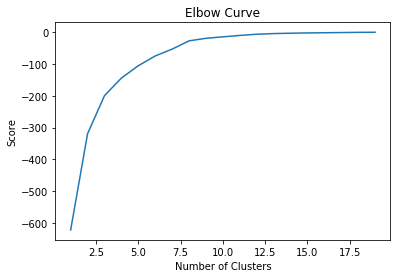

In [20]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

paris_grouped_clustering = paris_grouped_total.drop('Area', 1)

score = [kmeans[i].fit(paris_grouped_clustering).score(paris_grouped_clustering) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [21]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([3, 4, 3, 1, 3, 1, 7, 5, 0, 1, 1, 6, 1, 0, 1, 3, 1, 2, 1, 3],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = NBData

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

paris_merged.dropna(axis=0, inplace=True) 

paris_merged = paris_merged.astype({"Cluster Labels": int})

paris_merged.head()

,Nr,Name,Area,Density,Radius,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,17th,Batignolles-Monceau,5.669,28.277,1343,48.884224,2.322364,3,Wine Bar,Cocktail Bar,Pub,Lounge,Beer Bar
1,2nd,Bourse,0.992,20.867,562,48.868743,2.341688,4,Wine Bar,Cocktail Bar,Nightclub,Pub,Beer Bar
17,18th,Butte-Montmartre,6.005,31.424,1382,48.890012,2.346467,3,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge
18,19th,Buttes-Chaumont,6.786,27.586,1470,48.889343,2.384360,1,Beer Bar,Bistro,Pub,Lounge,Cocktail Bar
9,10th,Entrepôt,2.892,30.705,959,48.876106,2.359910,3,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge


Finally, let's visualize the resulting clusters

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Name'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Lets Analyze the Cluster that concerns the Neighborhood in question

Popincourt is considered part of Cluster nr. 3 so lets look at all neighborhoods from Cluster nr. 3.

#### Cluster 3

In [26]:
cluster_3 = paris_merged[paris_merged["Cluster Labels"] == 3]

cluster_3

,Nr,Name,Area,Density,Radius,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,17th,Batignolles-Monceau,5.669,28.277,1343,48.884224,2.322364,3,Wine Bar,Cocktail Bar,Pub,Lounge,Beer Bar
17,18th,Butte-Montmartre,6.005,31.424,1382,48.890012,2.346467,3,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge
9,10th,Entrepôt,2.892,30.705,959,48.876106,2.359910,3,Wine Bar,Cocktail Bar,Pub,Beer Bar,Lounge
10,11th,Popincourt,3.666,41.598,1080,48.858416,2.379703,3,Wine Bar,Cocktail Bar,Beer Bar,Pub,Nightclub
7,8th,Élysée,3.881,9.972,1111,48.877316,2.317261,3,Wine Bar,Pub,Nightclub,Cocktail Bar,Bistro


#### Analyzing most common venues in the Cluster

We can see that **Wine Bar** is the top common venue in all neighborhoods. **Cocktail Bar** is  in top 2 in four neighborhoods and its in the top 5 of the other neighborhood and **Pub** is in the top 4 of all neighborhoods. Those three are the most important venue categories. We will also include **Beer Bar** since it appears in the top 5 of all but one neighborhood. So lets prepare a dataframe to look at the number of venues from each category in each neighborhood.

In [27]:
#Lets drop the collumns that are no longer needed
cluster_3.drop(['Density','Radius', 'Latitude','Longitude', 'Cluster Labels','5th Most Common Venue'], axis=1, inplace = True)

#And lets rename the remaining columns based on Venue Categories that we are interested in
cluster_3.columns = ['Nr','Name','Area','Wine Bar','Cocktail Bar','Pub','Beer Bar']

cluster_3

,Nr,Name,Area,Wine Bar,Cocktail Bar,Pub,Beer Bar
16,17th,Batignolles-Monceau,5.669,Wine Bar,Cocktail Bar,Pub,Lounge
17,18th,Butte-Montmartre,6.005,Wine Bar,Cocktail Bar,Pub,Beer Bar
9,10th,Entrepôt,2.892,Wine Bar,Cocktail Bar,Pub,Beer Bar
10,11th,Popincourt,3.666,Wine Bar,Cocktail Bar,Beer Bar,Pub
7,8th,Élysée,3.881,Wine Bar,Pub,Nightclub,Cocktail Bar


In [28]:
#Now lets get data for number of venues from each category
for i in range(len(cluster_3)):
  cluster_3.iat[i,3]=paris_grouped_total.at[cluster_3.iat[i,1],'Wine Bar']
  cluster_3.iat[i,4]=paris_grouped_total.at[cluster_3.iat[i,1],'Cocktail Bar']
  cluster_3.iat[i,5]=paris_grouped_total.at[cluster_3.iat[i,1],'Pub']
  cluster_3.iat[i,6]=paris_grouped_total.at[cluster_3.iat[i,1],'Beer Bar']
cluster_3

,Nr,Name,Area,Wine Bar,Cocktail Bar,Pub,Beer Bar
16,17th,Batignolles-Monceau,5.669,2.29317,1.58758,1.58758,0.529194
17,18th,Butte-Montmartre,6.005,1.49875,1.49875,1.33222,0.999167
9,10th,Entrepôt,2.892,3.45781,2.42047,1.72891,1.03734
10,11th,Popincourt,3.666,3.27332,3.00055,1.36388,1.36388
7,8th,Élysée,3.881,2.83432,1.54599,2.83432,0.515331


#### Comparing Popincourt to its Cluster mean

Finaly lets compare Popincourt number of venues of each category to the mean of the Cluster. This way we will be able to see which type of venue is lacking comparing to the rest of neighborhoods in the cluster.

In [29]:
Popincourt = cluster_3[cluster_3["Name"] == 'Popincourt']

Popincourt.iat[0,3]=(paris_grouped_total.at['Popincourt','Wine Bar']/cluster_3.loc[:,"Wine Bar"].mean()-1)*100
Popincourt.iat[0,4]=(paris_grouped_total.at['Popincourt','Cocktail Bar']/cluster_3.loc[:,"Cocktail Bar"].mean()-1)*100
Popincourt.iat[0,5]=(paris_grouped_total.at['Popincourt','Pub']/cluster_3.loc[:,"Pub"].mean()-1)*100
Popincourt.iat[0,6]=(paris_grouped_total.at['Popincourt','Beer Bar']/cluster_3.loc[:,"Beer Bar"].mean()-1)*100

Popincourt


,Nr,Name,Area,Wine Bar,Cocktail Bar,Pub,Beer Bar
10,11th,Popincourt,3.666,22.5286,49.2313,-22.9175,53.4205


#### Final Remarks

Looking at the final results we see that the only category where Popincourt has below average number of venues is **Pub**, so that will be our recommendation to Louis. Both **Cocktail Bar** and **Beer Bar** are more than 50% above average so I would stay away from those options. **Wine Bar** is just 16% above average so could be a possible alternative to our first choice of **Pub**.

### Thank you for checking my Jupyter file!

This notebook was created by [André Santos](https://github.com/knoxvillage/Coursera_Capstone_IBM).